# Hancitor Config Extraction

Notes from our live stream where we reverse engineered the Hancitor DLL and built a static config extractor for it.

<a href="https://www.youtube.com/watch?v=OQuRwpUTBpQ" target="_blank"><img src="http://img.youtube.com/vi/OQuRwpUTBpQ/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="240" height="180" border="10" /></a>

## Malware Sample
- [Malware Traffic Analysis Sample 1](https://www.malware-traffic-analysis.net/2021/09/02/index.html)
- [Unpacked Sample (malshare)](https://malshare.com/sample.php?action=detail&hash=39ae285d4a7436eec52ee4da032da13132cdf259768de8a0e396ad20245fe330)

## References
[DFIR Report Hancitor](https://thedfirreport.com/2021/06/28/hancitor-continues-to-push-cobalt-strike/)

## Setup Imports

We are going to need some libraries to get our config extractor working.
- **pefile** - Parse data into a PE format. [Read the docs.](https://github.com/erocarrera/pefile)
- **re** - Use a regular expression to locate our config data. [Read the docs.](https://docs.python.org/3/library/re.html)
- **struct** - Convert binary data into numeric values. [Read the docs.](https://docs.python.org/3/library/struct.html)
- **hashlib** - Generate a SHA1 hash. [Read the docs.](https://docs.python.org/3/library/hashlib.html)

In [8]:
import pefile
import re
import struct
import hashlib

## Load The Malware

We need to read in the malware binary, remember to replace the path with a path the file on your own host. We also want to parse the data as a PE file so we can easily access the PE structure in our code.

In [9]:
file_path = r'/tmp/hancitor.bin'
data = open(file_path,'rb').read()
pe = pefile.PE(data=data)

## Use A Regular Expression to Locate The Decryption Code
We can use a regulare expression to find the code that is used to setup the arguments for the config decryption function. The key is to assume that the config length will say the same 0x2000 so we can use this as a marker in the code.

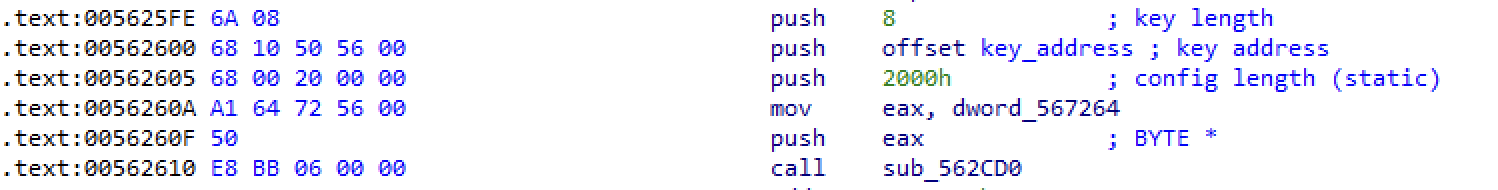

The `(.)` in our regular expression are a wildcard -- match any bytes -- in a capture group. The capture group can then be used to extract the data that was matched by the wildcard. In this case we use a capture group to pull the size of the key and the address of the key. 


In [10]:
key = rb'\x6a(.)\x68(....)\x68\x00\x20\x00\x00'
m = re.search(key, data)
if m != None:
    print("key length: %r" % m.group(1))
    print("key address: %r" % m.group(2))

key length: b'\x08'
key address: b'\x10PV\x00'


## Convert The Extracted Key Information
The key information extracted in our capture groups is binary so it must be converted into a data type to be used in our scipt. WE can use the `struct` library to do this. The `'b'` signifies that we are converting a byte and the `'<I'` signifies that we are converting an unsigned integer (DWORD) stored in little-endian format. 

In [11]:
struct.unpack('b', m.group(1))[0]

8

In [12]:
hex(struct.unpack('<I', m.group(2))[0])

'0x565010'

## Use The Key Information To Extract The Key Data

Now that we have the key length and key address we can use this information to extract the key data, and the config data (which directly follows the key in the binary). The key address needs to be converted into a **file offset** so we can locate that data in our file. 

To convert from an address in the PE file to a file offset we must first convert the address into a **relative virtual address (RVA)** then we can use the build in pefile function `get_offset_from_rva` to convert the RVA to a file offset.

Once we have the file offset of the key data we can extract the key and the config from our file.

In [13]:
key_len = struct.unpack('b', m.group(1))[0]
key_address = struct.unpack('<I', m.group(2))[0]
key_rva = key_address - pe.OPTIONAL_HEADER.ImageBase
key_offset = pe.get_offset_from_rva(key_rva)
key_data = data[key_offset:key_offset+key_len]
config_data = data[key_offset+key_len:key_offset+key_len+0x2000]

## Hash The Key Data To Create The Key

The config decryption key is the first 5 bytes of a **sha1** hash of the key data. We can use the hashlib library to create the key hash.

In [14]:
m = hashlib.sha1()
m.update(key_data)
key = m.digest()[:5]

## RC4 Decryption

The actual decryption algorithm is RC4. If you want to learn more about RC4 you can check out our [RC4 Tutorial](https://www.youtube.com/watch?v=CiJocXXMXK4).

In [15]:
def rc4crypt(data, key):
    #If the input is a string convert to byte arrays
    if type(data) == str:
        data = data.encode('utf-8')
    if type(key) == str:
        key = key.encode('utf-8')
    x = 0
    box = list(range(256))
    for i in range(256):
        x = (x + box[i] + key[i % len(key)]) % 256
        box[i], box[x] = box[x], box[i]
    x = 0
    y = 0
    out = []
    for c in data:
        x = (x + 1) % 256
        y = (y + box[x]) % 256
        box[x], box[y] = box[y], box[x]
        out.append(c ^ box[(box[x] + box[y]) % 256])
    return bytes(out)

## Parsing The Config

Once we have the config decrypted we can parse out the BUILD and the C2 list.

In [16]:
config = rc4crypt(config_data, key)
build_id = config.split(b'\x00')[0]
c2_string = b''
for s in config.split(b'\x00')[1:]:
    if s != b'':
        c2_string = s
        break
c2_list = c2_string.split(b'|')
print("BUILD: %s" % build_id)
for c2 in c2_list:
    if c2 != b'':
        print("C2: %s" % c2)

BUILD: b'0109_iqwnm'
C2: b'http://asinvotheir.com/8/forum.php'
C2: b'http://ditrismale.ru/8/forum.php'
C2: b'http://clatrommon.ru/8/forum.php'
